In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#cd "/content/drive/MyDrive/581-final-project"

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
from google.colab import files

In [ ]:
def tensor_to_img(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
'''
import numpy as np
import scipy.io
import imageio

MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

def load_img_2(path):
    image = imageio.imread(path)
    # Resize the image for convnet input, there is no change but just
    # add an extra dimension.
    image = np.reshape(image, ((1,) + image.shape))
    # Input to the VGG model expects the mean to be subtracted.
    image = image - MEAN_VALUES
    return image

def save_img_2(path, img):
    out = img + MEAN_VALUES
    out = out[0]
    imageio.imwrite(path, out)
    files.download(path)
'''

'\nimport numpy as np\nimport scipy.io\nimport imageio\n\nMEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))\n\ndef load_img_2(path):\n    image = imageio.imread(path)\n    # Resize the image for convnet input, there is no change but just\n    # add an extra dimension.\n    image = np.reshape(image, ((1,) + image.shape))\n    # Input to the VGG model expects the mean to be subtracted.\n    image = image - MEAN_VALUES\n    return image\n\ndef save_img_2(path, img):\n    out = img + MEAN_VALUES\n    out = out[0]\n    imageio.imwrite(path, out)\n    files.download(path)\n'

In [ ]:
def imshow(img, title=None):
  if len(img.shape) > 3:
    img = tf.squeeze(img, axis=0)

  plt.imshow(img)
  if title:
    plt.title(title)

In [ ]:
def clip_img(img):
  return tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
def generate_noise_img(content_image, noise_ratio = 0.75):
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """
    noise_image = np.random.uniform(
            -20, 20,
            (1, content_img.shape[1], content_img.shape[0], 3)).astype('float32')
    # White noise image from the content representation. Take a weighted average
    # of the values
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

In [ ]:
content_img_path = "/content/sample_data/triangular.jpg"
style_img_path = "/content/sample_data/starry-night-print-by-vincent-van-gogh-vincent-van-gogh.jpg"

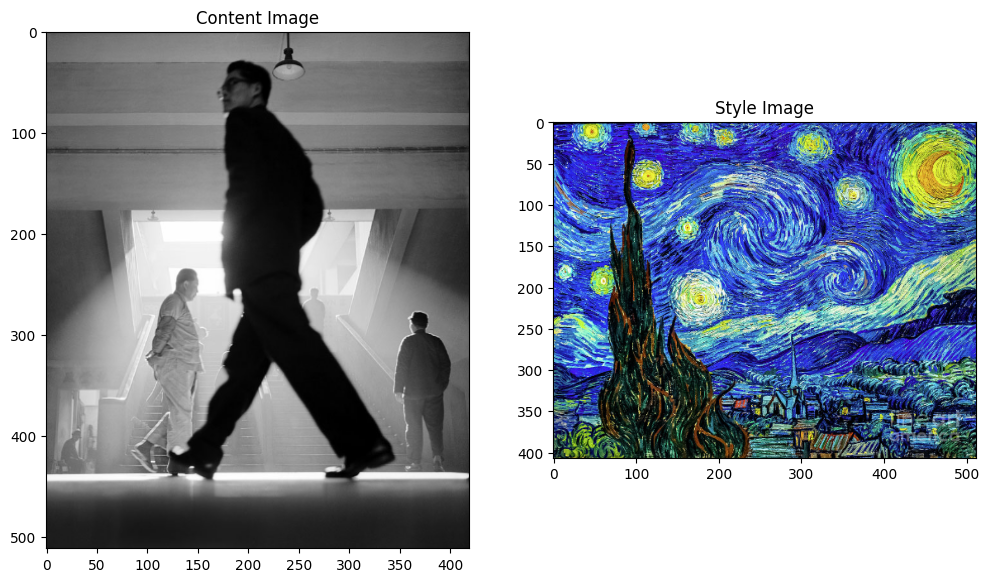

In [ ]:
content_img = load_img(content_img_path)
style_img = load_img(style_img_path)

#content_img = load_img_2(content_img_path)
#style_img = load_img_2(style_img_path)

plt.subplot(1, 2, 1)
imshow(content_img, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_img, 'Style Image')

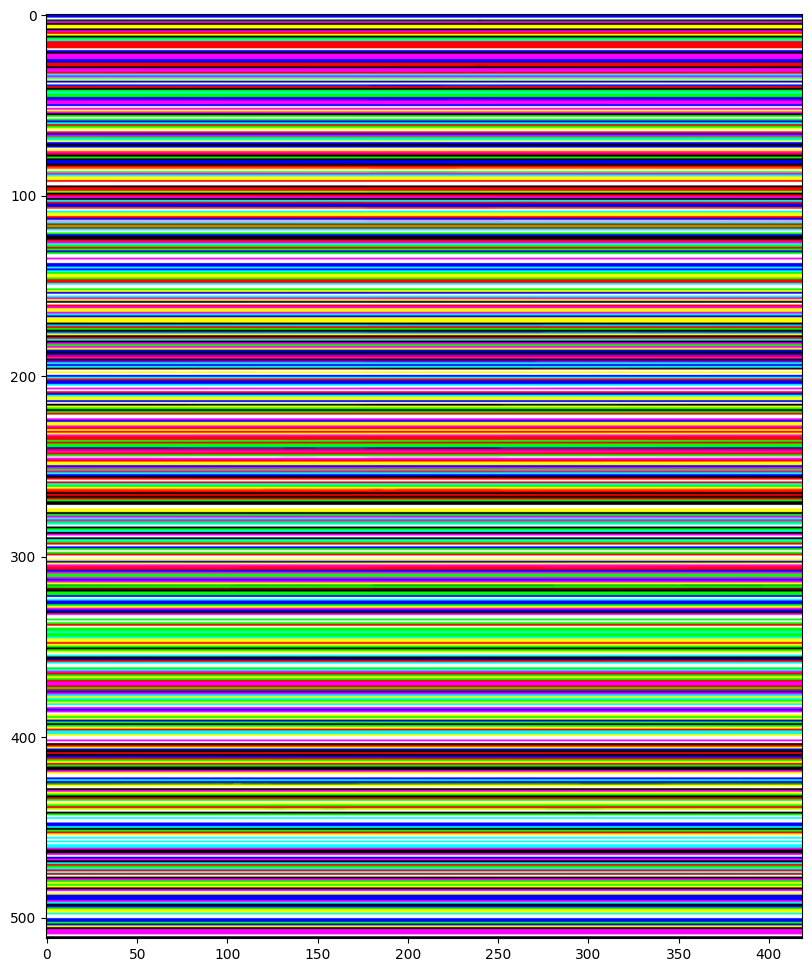

In [ ]:
noise_img = generate_noise_img(content_img, 0.8)
imshow(noise_img[0])

In [ ]:
# load vgg19
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
# define content & style layers
content_layers = ['block4_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""

  # load vgg pretrained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_img*255)

In [ ]:
def gram_matrix(v):
  result = tf.linalg.einsum('bijc,bijd->bcd', v, v) # 'batch, i, j, filters'
  input_shape = tf.shape(v)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)

    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

In [ ]:
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

In [ ]:
# hyperparameters
style_weight=1e-1
content_weight=1e3
total_variation_weight=30

In [ ]:
# set up gradient descent with an Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=1.2, beta_1=0.99, epsilon=1e-1)
output_img = tf.Variable(content_img)

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(img):
  with tf.GradientTape() as tape:
    outputs = extractor(img)
    loss = style_content_loss(outputs)
    loss += tf.cast(total_variation_weight*tf.image.total_variation(img), tf.float32)
    tf.print("\ntotal loss:")
    tf.print(loss)

  # tf.GradientTape
  gradients = tape.gradient(loss, img)
  opt.apply_gradients([(gradients, img)])
  img.assign(clip_img(img))

Epoch: 1

total loss:
[6.50065e+08]
  1/100 [..............................] - ETA: 10:26
total loss:
[650009792]
  2/100 [..............................] - ETA: 12:35
total loss:
[649954432]
  3/100 [..............................] - ETA: 11:14
total loss:
[649899136]
  4/100 [>.............................] - ETA: 11:34
total loss:
[649843712]
  5/100 [>.............................] - ETA: 11:03
total loss:
[649788736]
  6/100 [>.............................] - ETA: 11:10
total loss:
[649733504]
  7/100 [=>............................] - ETA: 10:49
total loss:
[649679168]
  8/100 [=>............................] - ETA: 10:51
total loss:
[649624960]
  9/100 [=>............................] - ETA: 10:35
total loss:
[649571200]
 10/100 [==>...........................] - ETA: 10:35
total loss:
[649517568]
 11/100 [==>...........................] - ETA: 10:20
total loss:
[649464320]
 12/100 [==>...........................] - ETA: 10:19
total loss:
[649411392]
 13/100 [==>................

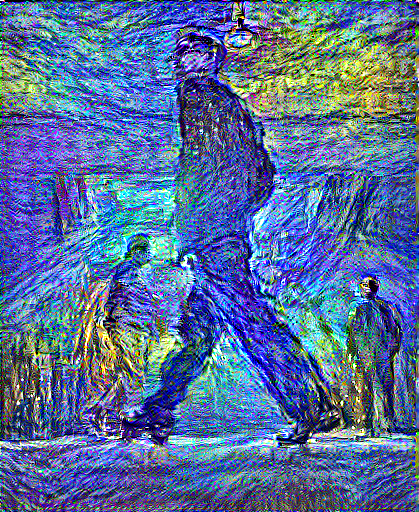

Epoch: 2

total loss:
[645229120]
  1/100 [..............................] - ETA: 19:25:41
total loss:
[645187648]
  2/100 [..............................] - ETA: 12:32   
total loss:
[645146240]
  3/100 [..............................] - ETA: 11:17
total loss:
[645105152]
  4/100 [>.............................] - ETA: 11:35
total loss:
[645063808]
  5/100 [>.............................] - ETA: 11:03
total loss:
[645022592]
  6/100 [>.............................] - ETA: 11:11
total loss:
[644981312]
  7/100 [=>............................] - ETA: 10:49
total loss:
[644940352]
  8/100 [=>............................] - ETA: 10:52
total loss:
[644899328]
  9/100 [=>............................] - ETA: 10:35
total loss:
[644858560]
 10/100 [==>...........................] - ETA: 10:35
total loss:
[644817792]
 11/100 [==>...........................] - ETA: 10:20
total loss:
[644776704]
 12/100 [==>...........................] - ETA: 10:20
total loss:
[644735680]
 13/100 [==>............

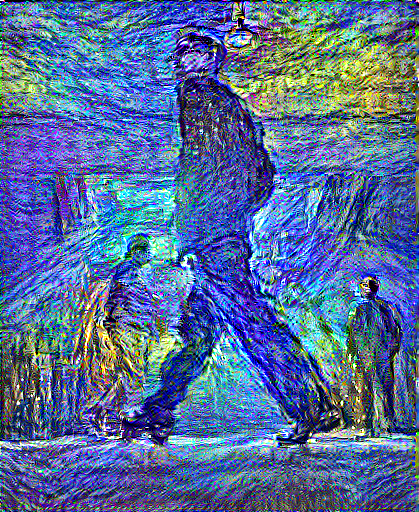

Epoch: 3

total loss:
[641541376]
  1/100 [..............................] - ETA: 38:43:58
total loss:
[641508800]
  2/100 [..............................] - ETA: 12:40   
total loss:
[641476544]
  3/100 [..............................] - ETA: 11:20
total loss:
[641444224]
  4/100 [>.............................] - ETA: 11:39
total loss:
[641411904]
  5/100 [>.............................] - ETA: 11:43
total loss:
[641379648]
  6/100 [>.............................] - ETA: 11:47
total loss:
[641347200]
  7/100 [=>............................] - ETA: 11:20
total loss:
[641314560]
  8/100 [=>............................] - ETA: 11:18
total loss:
[641282304]
  9/100 [=>............................] - ETA: 10:58
total loss:
[641249920]
 10/100 [==>...........................] - ETA: 10:57
total loss:
[641217728]
 11/100 [==>...........................] - ETA: 10:41
total loss:
[641185600]
 12/100 [==>...........................] - ETA: 10:38
total loss:
[641153472]
 13/100 [==>............

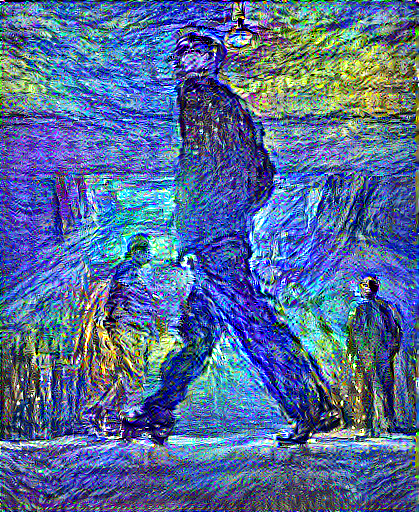

Epoch: 4

total loss:
[638581120]
  1/100 [..............................] - ETA: 58:08:10
total loss:
[638554368]
  2/100 [..............................] - ETA: 10:16   
total loss:
[638527616]
  3/100 [..............................] - ETA: 11:19
total loss:
[638500864]
  4/100 [>.............................] - ETA: 10:51
total loss:
[638474240]
  5/100 [>.............................] - ETA: 11:07
total loss:
[638447936]
  6/100 [>.............................] - ETA: 10:45
total loss:
[638421504]
  7/100 [=>............................] - ETA: 10:52
total loss:
[638395136]
  8/100 [=>............................] - ETA: 10:41
total loss:
[638368512]
  9/100 [=>............................] - ETA: 11:00
total loss:
[638341824]
 10/100 [==>...........................] - ETA: 10:44
total loss:
[638315264]
 11/100 [==>...........................] - ETA: 10:42
total loss:
[638288960]
 12/100 [==>...........................] - ETA: 10:27
total loss:
[638262720]
 13/100 [==>............

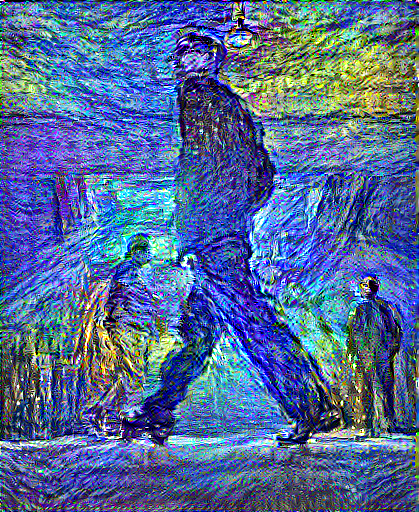

Epoch: 5

total loss:
[636146752]
  1/100 [..............................] - ETA: 77:36:34
total loss:
[636124800]
  2/100 [..............................] - ETA: 10:42   
total loss:
[636102848]
  3/100 [..............................] - ETA: 11:22
total loss:
[636080640]
  4/100 [>.............................] - ETA: 11:00
total loss:
[636058432]
  5/100 [>.............................] - ETA: 11:09
total loss:
[636036096]
  6/100 [>.............................] - ETA: 10:52
total loss:
[636013568]
  7/100 [=>............................] - ETA: 10:55
total loss:
[635991360]
  8/100 [=>............................] - ETA: 10:59
total loss:
[635969216]
  9/100 [=>............................] - ETA: 11:04
total loss:
[635946944]
 10/100 [==>...........................] - ETA: 10:47
total loss:
[635924672]
 11/100 [==>...........................] - ETA: 10:46
total loss:
[635902720]
 12/100 [==>...........................] - ETA: 10:33
total loss:
[635880768]
 13/100 [==>............

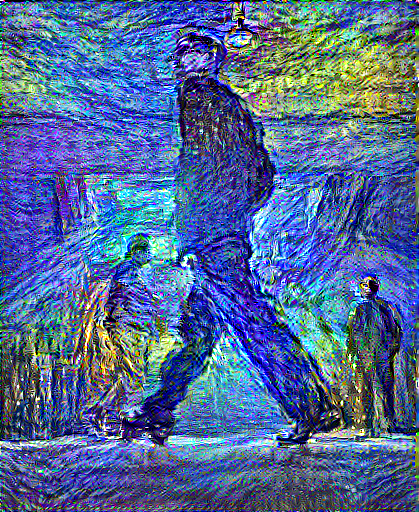

Epoch: 6

total loss:
[634124928]
  1/100 [..............................] - ETA: 97:03:22
total loss:
[634106624]
  2/100 [..............................] - ETA: 12:44   
total loss:
[634088512]
  3/100 [..............................] - ETA: 11:26
total loss:
[634070336]
  4/100 [>.............................] - ETA: 11:43
total loss:
[634052032]
  5/100 [>.............................] - ETA: 11:12
total loss:
[634033728]
  6/100 [>.............................] - ETA: 11:53
total loss:
[634015296]
  7/100 [=>............................] - ETA: 11:34
total loss:
[633996800]
  8/100 [=>............................] - ETA: 11:28
total loss:
[633978304]
  9/100 [=>............................] - ETA: 11:11
total loss:
[633960192]
 10/100 [==>...........................] - ETA: 11:03
total loss:
[633942080]
 11/100 [==>...........................] - ETA: 10:50
total loss:
[633924096]
 12/100 [==>...........................] - ETA: 10:43
total loss:
[633906112]
 13/100 [==>............

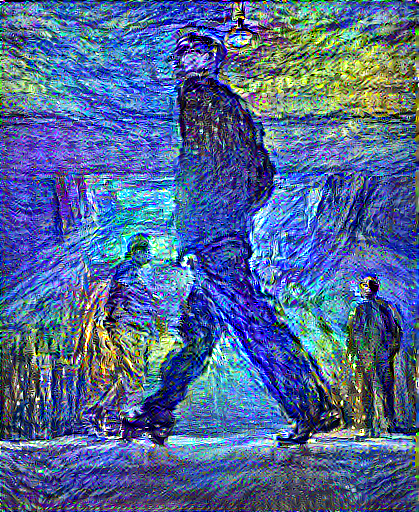

Epoch: 7

total loss:
[632418368]
  1/100 [..............................] - ETA: 116:38:53
total loss:
[632402688]
  2/100 [..............................] - ETA: 14:34    
total loss:
[632387072]
  3/100 [..............................] - ETA: 12:22
total loss:
[632371584]
  4/100 [>.............................] - ETA: 12:18
total loss:
[632356032]
  5/100 [>.............................] - ETA: 11:40
total loss:
[632340480]
  6/100 [>.............................] - ETA: 11:41
total loss:
[632324800]
  7/100 [=>............................] - ETA: 11:16
total loss:
[632309184]
  8/100 [=>............................] - ETA: 11:15
total loss:
[632293504]
  9/100 [=>............................] - ETA: 10:56
total loss:
[632277568]
 10/100 [==>...........................] - ETA: 10:55
total loss:
[632261760]
 11/100 [==>...........................] - ETA: 10:39
total loss:
[632245952]
 12/100 [==>...........................] - ETA: 10:37
total loss:
[632230208]
 13/100 [==>..........

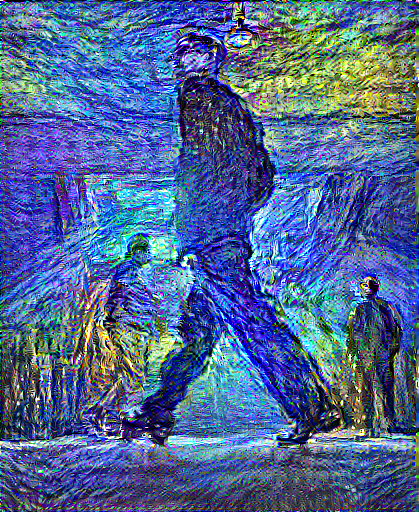

Epoch: 8

total loss:
[630947904]
  1/100 [..............................] - ETA: 136:20:13
total loss:
[6.30934e+08]
  2/100 [..............................] - ETA: 10:24    
total loss:
[630920256]
  3/100 [..............................] - ETA: 11:29
total loss:
[630906688]
  4/100 [>.............................] - ETA: 11:03
total loss:
[630893184]
  5/100 [>.............................] - ETA: 11:17
total loss:
[630879680]
  6/100 [>.............................] - ETA: 10:55
total loss:
[630866048]
  7/100 [=>............................] - ETA: 11:02
total loss:
[630852224]
  8/100 [=>............................] - ETA: 10:48
total loss:
[630838464]
  9/100 [=>............................] - ETA: 10:48
total loss:
[630824832]
 10/100 [==>...........................] - ETA: 10:36
total loss:
[630811072]
 11/100 [==>...........................] - ETA: 10:33
total loss:
[630797376]
 12/100 [==>...........................] - ETA: 10:21
total loss:
[630783936]
 13/100 [==>........

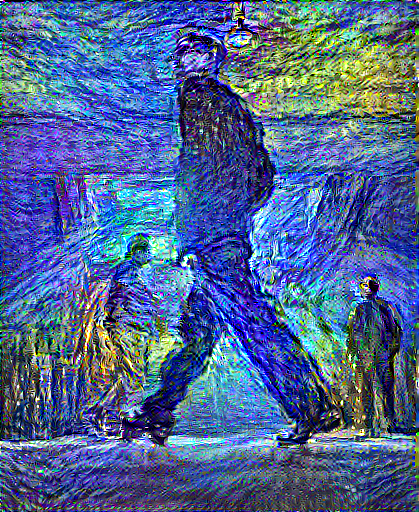

Epoch: 9

total loss:
[629659136]
  1/100 [..............................] - ETA: 155:59:08
total loss:
[629646848]
  2/100 [..............................] - ETA: 10:23    
total loss:
[629634560]
  3/100 [..............................] - ETA: 11:29
total loss:
[629622400]
  4/100 [>.............................] - ETA: 11:01
total loss:
[629610304]
  5/100 [>.............................] - ETA: 11:16
total loss:
[629598272]
  6/100 [>.............................] - ETA: 10:53
total loss:
[629586176]
  7/100 [=>............................] - ETA: 11:00
total loss:
[6.29574e+08]
  8/100 [=>............................] - ETA: 10:42
total loss:
[629561792]
  9/100 [=>............................] - ETA: 10:46
total loss:
[629549632]
 10/100 [==>...........................] - ETA: 10:32
total loss:
[629537536]
 11/100 [==>...........................] - ETA: 10:32
total loss:
[629525504]
 12/100 [==>...........................] - ETA: 10:19
total loss:
[629513408]
 13/100 [==>........

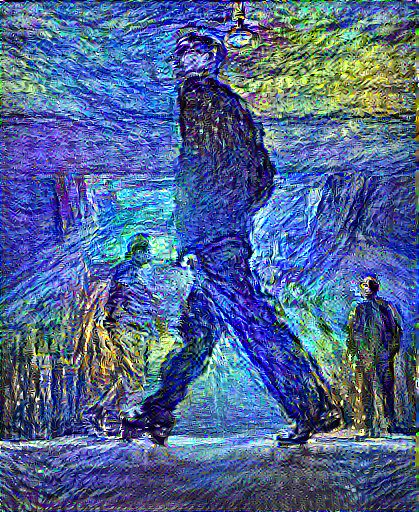

Epoch: 10

total loss:
[628513536]
  1/100 [..............................] - ETA: 175:41:56
total loss:
[628503040]
  2/100 [..............................] - ETA: 10:27    
total loss:
[628492608]
  3/100 [..............................] - ETA: 11:34
total loss:
[628482240]
  4/100 [>.............................] - ETA: 11:02
total loss:
[6.28472e+08]
  5/100 [>.............................] - ETA: 11:19
total loss:
[628461440]
  6/100 [>.............................] - ETA: 10:58
total loss:
[628450944]
  7/100 [=>............................] - ETA: 11:06
total loss:
[628440448]
  8/100 [=>............................] - ETA: 10:49
total loss:
[628429952]
  9/100 [=>............................] - ETA: 10:52
total loss:
[628419584]
 10/100 [==>...........................] - ETA: 10:37
total loss:
[628409408]
 11/100 [==>...........................] - ETA: 10:37
total loss:
[628399296]
 12/100 [==>...........................] - ETA: 10:24
total loss:
[6.28389e+08]
 13/100 [==>.....

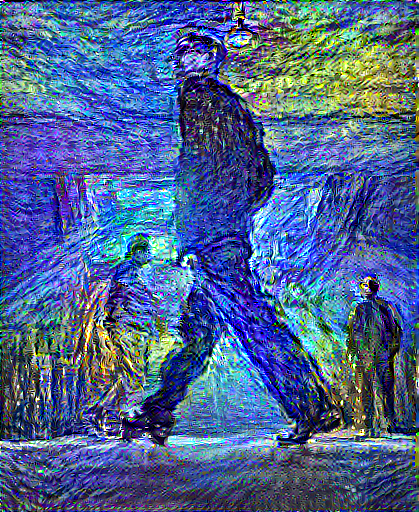

Total time: 7099.1


"\nwith open(log_path, 'w') as f:\n    f.write(cap.stdout)\n"

In [ ]:
import time
import cv2
import os
from datetime import datetime

start = time.time()
timestamp = datetime.now().strftime("%Y-%m-%d-%H:%M:%S%z")

epochs = 10
steps_per_epoch = 100

progbar = tf.keras.utils.Progbar(steps_per_epoch)

step = 0
epoch = 0

log_path = "logs/epochs{0}-steps{1}-sw{2}-cw{3}-tvw{4}.txt".format(epoch, steps_per_epoch, style_weight, content_weight, total_variation_weight)
img_dir = "output_images/{!s}".format(timestamp)
#if (os.path.exists(img_dir) == False):
  #os.mkdir(img_dir)

for n in range(epochs):
  step = 0
  epoch += 1
  print("Epoch: {}".format(epoch))
  for m in range(steps_per_epoch):
    step += 1
    train_step(output_img)
    progbar.update(step)
  #display.clear_output(wait=True)
  display.display(tensor_to_img(output_img))
  img_name = "/epoch_{}.jpg".format(epoch)
  img_path = img_dir + img_name
  #cv2.imwrite(img_path , np.asarray(tensor_to_img(output_img)))

end = time.time()
print("Total time: {:.1f}".format(end-start))

'''
with open(log_path, 'w') as f:
    f.write(cap.stdout)
'''
